In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def derivative(y,t):
    return torch.autograd.grad(
        y,t,
        grad_outputs=torch.ones_like(y),
        create_graph=True,
        retain_graph=True
    )[0]

In [3]:
class Sin(nn.Module):
    def forward(self, x): return torch.sin(x)

In [4]:
#Model
class PINN(nn.Module):
    def __init__(self,hidden_dim=32,hidden_layers=4):
        super(PINN, self).__init__()
        layers=[]
        layers.append(nn.Linear(1,hidden_dim))
        layers.append(nn.Tanh())
        for _ in range(hidden_layers-1):
            layers.append(nn.Linear(hidden_dim,hidden_dim))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_dim,1))
        self.net=nn.Sequential(*layers)
    def forward(self,t):
        return self.net(t)

In [5]:
e=8.0
x0=1.0
v0=0.0
t_min,t_max=0.0,3.0
w0=5.0

Text(0.5, 1.0, 'VDP Position Plot')

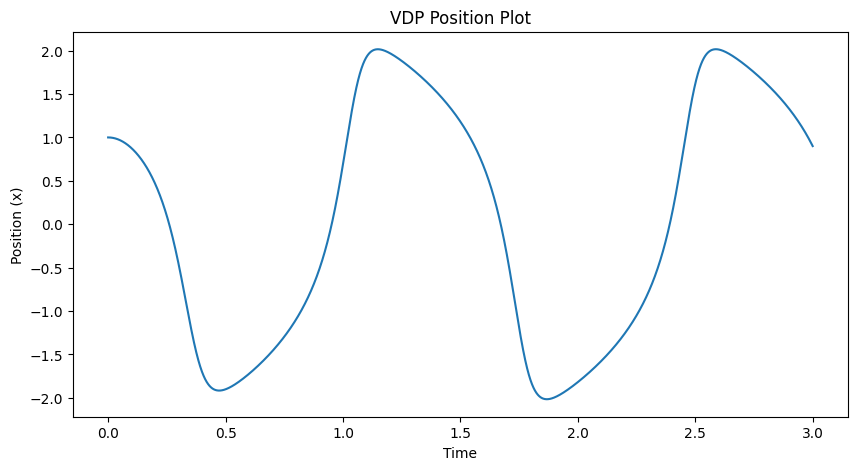

In [6]:
from __future__ import division, print_function
def rk4_step(f, x, t, dt, e, w0):
    k1 = dt * f(x, t, e, w0)
    k2 = dt * f(x + 0.5*k1, t + 0.5*dt, e, w0)
    k3 = dt * f(x + 0.5*k2, t + 0.5*dt, e, w0)
    k4 = dt * f(x + k3, t + dt, e, w0)
    return x + (k1 + 2*k2 + 2*k3 + k4) / 6

def van_der_pol_oscillator(x, t, e, w0):
    dxdt = x[1]
    dvdt = e * (1 - x[0]**2) * x[1] -(w0 **2)* x[0]
    return np.array([dxdt, dvdt])

nSteps = 10000
tStep = (t_max-t_min)/nSteps #time step

tPoints = np.arange(t_min,t_max, tStep)
ic=[1.0,0.0]
solution = np.zeros((len(tPoints), 2))
solution[0]=ic

# Solve with RK4
for i in range(1, len(tPoints)):
    solution[i] = rk4_step(van_der_pol_oscillator, solution[i-1], tPoints[i-1], tStep, e, w0)

xPoints = solution[:,0]
plt.figure(figsize=(10, 5))
plt.plot(tPoints, solution[:, 0])
plt.xlabel('Time')
plt.ylabel('Position (x)')
plt.title('VDP Position Plot')

# Plotting phase plot (v-x plot)
# plt.subplot(1, 2, 2)
# plt.plot(solution[:, 0], solution[:, 1])
# plt.xlabel('Position (x)')
# plt.ylabel('Velocity (v)')
# plt.title('VDP Phase Plot')

# plt.tight_layout()
# plt.show()

In [7]:
#Noisy_Data_generation
np.random.seed(0)
torch.manual_seed(123)
# N_data=50
# t_data_np=np.linspace(t_min,t_max,N_data)
# x_exact=true_solution(t_data_np,x0,v0,omega)
# noise=0.9*np.random.randn(*x_exact.shape)
# x_noisy=x_exact+noise
# t_data=torch.tensor(t_data_np.reshape(-1, 1), dtype=torch.float32, requires_grad=True)
# x_data=torch.tensor(x_noisy.reshape(-1, 1), dtype=torch.float32)

#Collocation_Points
N_f=1000
t_f=torch.linspace(t_min, t_max, N_f).view(-1, 1).requires_grad_(True)
#Boundary_Points
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)


In [ ]:
model=PINN()
optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
def loss_fn():
    # u = model(t_boundary)
    # loss1 = (torch.squeeze(u) - 1)**2
    # dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    # loss2 = (torch.squeeze(dudt) - 0)**2
    # u = model(t_physics)
    # dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    # d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    # loss3 = torch.mean((d2udt2)**2)
    #Data_loss
    # x_pred_data=model(t_data)
    # loss_data=torch.mean((x_pred_data - x_data)**2)
    #Boundary_Loss
    x_pred_b=model(t_boundary)
    dx_dt_b=derivative(x_pred_b, t_boundary)
    # dx_dt_b=torch.autograd.grad(x_pred_b, t_boundary, torch.ones_like(x_pred_b), create_graph=True)[0]
    loss_b=(torch.squeeze(dx_dt_b) - v0)**2+1e-1*(torch.squeeze(x_pred_b)-x0)**2

    #Physics_loss
    x_pred_f=model(t_f)
    dx_dt_f=derivative(x_pred_f, t_f)
    d2x_dt2_f=derivative(dx_dt_f, t_f)
    residual=d2x_dt2_f - e*(1 - x_pred_f**2)*dx_dt_f + (w0**2)*x_pred_f
    loss_phys=torch.mean(residual**2)

    #Energy_Loss
    # residual_e=0.5*(dx_dt_f)**2 + 0.25*omega**2*(x_pred_f)**4
    # loss_e=torch.mean(residual_e**2)
    return loss_b + 1e-4*loss_phys, loss_b.item(), loss_phys.item()

In [9]:
losses,boundary_losses, phys_losses=[],[],[]
for epoch in range(72001):
    optimizer.zero_grad()
    loss, l_b,l_phys=loss_fn()
    loss.backward()
    optimizer.step()
    if epoch%4000==0:
        print(f"Epoch {epoch}, Total Loss: {loss.item():.2e}, Boundary: {l_b:.2e}, Phys: {l_phys:.2e}")
        losses.append(loss.item())
        boundary_losses.append(l_b)
        phys_losses.append(l_phys)

Epoch 0, Total Loss: 1.36e-01, Boundary: 1.34e-01, Phys: 1.92e+01
Epoch 4000, Total Loss: 8.78e-03, Boundary: 3.54e-04, Phys: 8.43e+01
Epoch 8000, Total Loss: 8.77e-03, Boundary: 3.48e-04, Phys: 8.42e+01
Epoch 12000, Total Loss: 8.76e-03, Boundary: 3.46e-04, Phys: 8.42e+01
Epoch 16000, Total Loss: 8.76e-03, Boundary: 3.45e-04, Phys: 8.41e+01
Epoch 20000, Total Loss: 9.09e-03, Boundary: 7.01e-04, Phys: 8.39e+01
Epoch 24000, Total Loss: 8.76e-03, Boundary: 3.51e-04, Phys: 8.41e+01
Epoch 28000, Total Loss: 8.79e-03, Boundary: 3.80e-04, Phys: 8.41e+01
Epoch 32000, Total Loss: 8.75e-03, Boundary: 3.38e-04, Phys: 8.41e+01
Epoch 36000, Total Loss: 8.75e-03, Boundary: 3.41e-04, Phys: 8.41e+01
Epoch 40000, Total Loss: 8.75e-03, Boundary: 3.40e-04, Phys: 8.41e+01
Epoch 44000, Total Loss: 8.75e-03, Boundary: 3.44e-04, Phys: 8.41e+01
Epoch 48000, Total Loss: 8.75e-03, Boundary: 3.41e-04, Phys: 8.41e+01
Epoch 52000, Total Loss: 8.75e-03, Boundary: 3.39e-04, Phys: 8.41e+01
Epoch 56000, Total Loss: 8

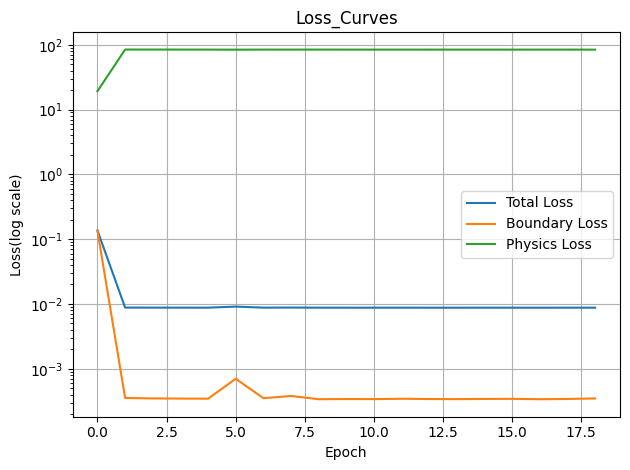

In [10]:
plt.plot(np.array(losses),label="Total Loss")
plt.plot(np.array(boundary_losses),label="Boundary Loss")
# plt.plot(np.array(boundary2_losses),label="Boundary 2 Loss")
plt.plot(np.array(phys_losses),label="Physics Loss")
# plt.plot(np.array(ener_losses),label="Energy Loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss(log scale)")
plt.title("Loss_Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

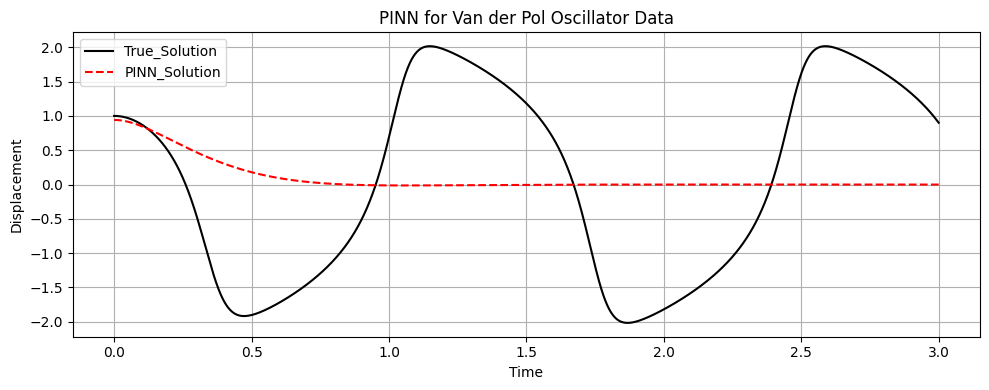

In [11]:
#Evaluation
t_test = torch.linspace(t_min, t_max, 4000).view(-1,1).requires_grad_(True)
x_pred = model(t_test).detach().numpy()
# from scipy.integrate import solve_ivp
# def vdp(t, y): return [y[1], e*omega*(1-y[0]**2)*y[1] - omega**2*y[0]]
# sol = solve_ivp(vdp, [t_min,t_max], [x0,v0], t_eval=t_test.detach().numpy().flatten())
# x_true = sol.y[0]
# x_true = true_solution(t_test.detach().numpy().flatten(), x0, v0, omega)

plt.figure(figsize=(10,4))
# plt.plot(t_dense,sol.y[0],'k-',label="True_Solution")
# plt.plot(t_test.detach(),x_pred,'r--',label="PINN_Prediction")
plt.plot(tPoints, xPoints, 'k-', label="True_Solution")
plt.plot(t_test.detach(), x_pred, 'r--', label="PINN_Solution")
# plt.legend(); plt.xlabel("t"); plt.ylabel("x(t)"); plt.show()
#plt.scatter(t_data.detach(),x_data.detach(),c='blue',label="Noisy_Data_Points",s=30,alpha=0.5)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Displacement")
plt.title("PINN for Van der Pol Oscillator Data")
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# plt.figure()
# plt.title("$v0$")
# plt.plot(v_0s, label="PINN estimate")
# plt.hlines(v0, 0, len(v_0s), label="True value", color="tab:green")
# plt.legend()
# plt.xlabel("Training step")
# plt.show()